# Experimenting with Heteroskedastic Matrix Factorization and its relationship with PCA #
Starting with homoskedastic MF

In [1]:
%pylab inline
import numpy as np
from scipy.sparse import spdiags
import empca

Populating the interactive namespace from numpy and matplotlib


In [2]:
nvec = 5
nx = 200
nobs = 100
x = np.linspace(0, np.pi, nx)
Ax = np.zeros((nx, nvec))
Cx = np.zeros((nvec, nobs))
for i in range(nvec):
    Ax[:,i] = np.sin((i+1)*x)
    Cx[i] = np.random.normal(scale=10/(i+1), size=nobs)

err = np.ones((nobs, nx))
data = (Ax.dot(Cx) + np.random.normal(scale=err).T).T

In [3]:
class HMF():
    def __init__(self, data, weights=None, nvec=5, seed=1):
        '''data[nobs, nvar], weights with same shape'''
        self.data = data
        self.weights = weights
        self.nobs = data.shape[0]
        self.nvar = data.shape[1]
        self.nvec = nvec
        self._chi2 = list()
        R = np.random.RandomState(seed)
        self.coeff = R.normal(size=(self.nvec, self.nobs))
        self.solve()
    
    def solve(self, niter=5):
        '''Iteratively solve for A and C using weights
        D[nvar,nobs] = A[nvar,nvec] C[nvec,nobs]
        self.data = D.T    #- input data
        self.mvec = A.T    #- model vectors
        self.coeff = C.T     #- coefficients of model vectors to represent data
        '''
        if self.weights is None:
            self.unweighted_solve()
            return
        
        D = self.data.T
        C = self.coeff
        for i in range(niter):
            #- Solve D.T[nobs,nvar] = C.T A.T
            if self.weights is None:
                A = np.linalg.solve(C.dot(C.T), C.dot(D.T)).T
            else:
                #- weighted requires solving one var at a time for all vec
                W = self.weights.T
                A = np.zeros((self.nvar, self.nvec))
                for j in range(self.nvar):
                    Wx = spdiags(W[j], [0], self.nobs, self.nobs)
                    A[j] = np.linalg.solve(C.dot(Wx.dot(C.T)), C.dot(W[j]*D[j]))

            #- Normalize vectors
            for j in range(self.nvec):
                A[:,j] /= np.linalg.norm(A[:,j])
            
            #- Solve D = A C
            if self.weights is None:
                C = np.linalg.solve(A.T.dot(A), A.T.dot(D))
            else:
                #- weighted requires solving one vec at a time
                for j in range(self.nobs):
                    Wx = spdiags(W[:,j], [0], self.nvar, self.nvar)
                    C[:,j] = np.linalg.solve(A.T.dot(Wx.dot(A)), A.T.dot(W[:,j]*D[:,j]))
            
            #- Calculate model and chi2 of the current iteration fit
            M = A.dot(C)
            self._chi2.append( np.sum((D-M)**2 * W) )

        self.mvec = A.T
        self.coeff = C.T
        self.model = M.T
    
    @property
    def chi2(self):
        return self._chi2[-1]

18641.5500515
14722.0741251


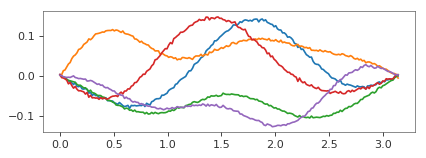

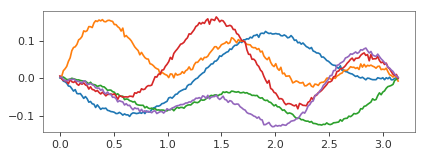

In [4]:
weights = 1/err**2
h = HMF(data, weights)
print(h.chi2)
figure(figsize=(6,2))
for i in range(h.nvec):
    plot(x, h.mvec[i])

mask = (np.random.uniform(size=data.shape)<0.8)
hx = HMF(data*mask+100*(~mask), weights*mask)
print(hx.chi2)
figure(figsize=(6,2))
for i in range(hx.nvec):
    plot(x, hx.mvec[i])

In [5]:
p = empca.empca(data*mask+100*(~mask), weights*mask)

       iter        R2             rchi2
EMPCA  1/25       0.15859524     57.19050001
EMPCA  2/25       0.93117417      4.64299577
EMPCA  3/25       0.97092795      1.96100113
EMPCA  4/25       0.97929468      1.39663500
EMPCA  5/25       0.98197665      1.21572658
EMPCA  6/25       0.98287929      1.15484458
EMPCA  7/25       0.98318533      1.13420523
EMPCA  8/25       0.98329026      1.12713085
EMPCA  9/25       0.98332685      1.12466531
EMPCA 10/25       0.98333987      1.12378834
EMPCA 11/25       0.98334461      1.12346894
EMPCA 12/25       0.98334639      1.12334927
EMPCA 13/25       0.98334709      1.12330283
EMPCA 14/25       0.98334737      1.12328397
EMPCA 15/25       0.98334749      1.12327586
EMPCA 16/25       0.98334755      1.12327212
EMPCA 17/25       0.98334758      1.12327027
EMPCA 18/25       0.98334759      1.12326929
EMPCA 19/25       0.98334760      1.12326873
EMPCA 20/25       0.98334760      1.12326840
EMPCA 21/25       0.98334761      1.12326821
EMPCA 22/25    

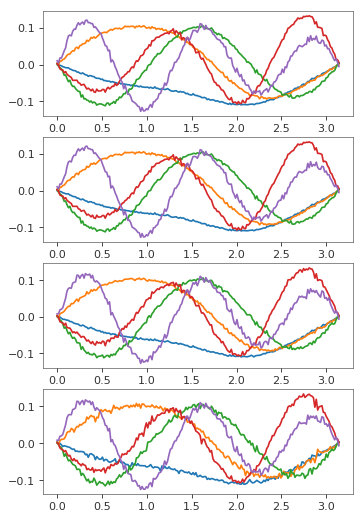

In [6]:
figure(figsize=(5,8))
subplot(411)
u0, s0, v0 = np.linalg.svd(data, full_matrices=False)
for i in range(nvec):
    plot(x, v0[i])

subplot(412)
u, s, v = np.linalg.svd(h.model, full_matrices=False)
for i in range(nvec):
    plot(x, v[i] * np.sign(np.dot(v0[i],v[i])))

subplot(413)
u, s, v = np.linalg.svd(hx.model, full_matrices=False)
for i in range(nvec):
    plot(x, v[i] * np.sign(np.dot(v0[i],v[i])))

subplot(414)
for i in range(nvec):
    plot(x, p.eigvec[i] * np.sign(np.dot(v0[i],p.eigvec[i])))

16327.8226223


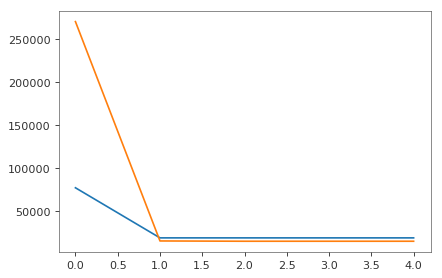

In [7]:
plot(h._chi2)
plot(hx._chi2)
empca_chi2 = np.sum((data-p.model)**2 * weights**2 * mask)
print(empca_chi2)

# Try HMF/PCA on QSO sample #

In [8]:
import fitsio
data = fitsio.read('training_sample_dr7_cleaned.fits', 1)
flux = data['FLUXNORM'][0]
err = data['ERRNORM'][0]
wave = data['RESTWAVE'][0]
redshifts = data['ZHW'][0]

ii = (err<10**-2.2)
err[ii] = 0.0
weights = (err != 0)/(err**2 + (err==0))

In [9]:
nspec_per_wave = np.sum(weights>0, axis=0)
ii = (nspec_per_wave >= 25)
wave = wave[ii]
flux = flux[:,ii]
err = err[:,ii]
weights = weights[:,ii]

In [10]:
flux.shape, weights.shape

((5272, 10313), (5272, 10313))

In [11]:
%time qso = HMF(flux, weights, nvec=10)
%time blat, foo, qpca = np.linalg.svd(qso.model, full_matrices=False)
%time em5 = empca.empca(flux, weights, nvec=10, niter=5)
%time em10 = empca.empca(flux, weights, nvec=10, niter=10)

CPU times: user 1min 11s, sys: 3.68 s, total: 1min 15s
Wall time: 1min 14s
CPU times: user 2min 6s, sys: 2.13 s, total: 2min 8s
Wall time: 2min 8s
       iter        R2             rchi2
EMPCA  1/ 5      -0.00569702    690.07133401
EMPCA  2/ 5      -0.10326306    185.21320942
EMPCA  3/ 5      -0.98491508    519.81648730
EMPCA  4/ 5      -1.19537308    938.59679118
EMPCA  5/ 5       0.16446969    333.81603974
R2: 0.925981780547
CPU times: user 3min 17s, sys: 15.6 s, total: 3min 33s
Wall time: 3min 36s
       iter        R2             rchi2
EMPCA  1/10      -0.00569702    690.07133401
EMPCA  2/10      -0.10326306    185.21320942
EMPCA  3/10      -0.98491508    519.81648730
EMPCA  4/10      -1.19537308    938.59679118
EMPCA  5/10       0.16446969    333.81603974
EMPCA  6/10       0.69654994     63.96804605
EMPCA  7/10       0.44616432    140.13792038
EMPCA  8/10       0.43726120    107.99531448
EMPCA  9/10       0.06746105    267.90410525
EMPCA 10/10      -4.29399479   1200.11081063
R2: 

In [17]:
qq = empca.Model(qpca[0:qso.nvec], flux, weights)

In [34]:
chi2 = dict()
chi2['EMPCA-5'] = np.sum((em5.model - em5.data)**2 * em5.weights) / (em5.data.size - 10)
chi2['EMPCA-10'] = np.sum((em10.model - em10.data)**2 * em10.weights) / (em10.data.size - 10)
chi2['HMF+PCA'] = np.sum((qq.model - qq.data)**2 * qq.weights) / (qq.data.size - 10)
chi2['HMF'] = np.sum((qso.model - qso.data)**2 * qso.weights) / (qso.data.size - 10)

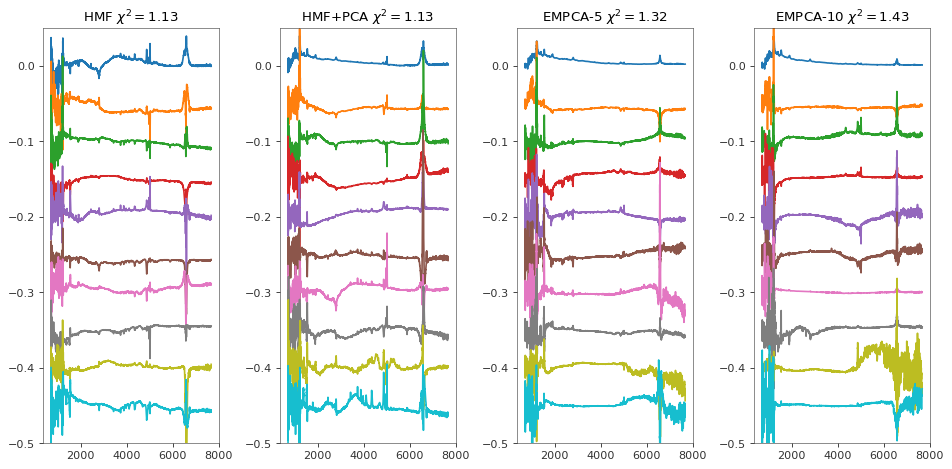

In [39]:
figure(figsize=(12,6))
methods = [(qso, 'HMF'), (qq, 'HMF+PCA'), (em5, 'EMPCA-5'), (em10, 'EMPCA-10')]
for i, (xpca, xtitle) in enumerate(methods):
    subplot(1,len(methods),1+i)
    for i in range(xpca.nvec):
        try:
            plot(wave, xpca.mvec[i] - 0.05*i)
        except:
            plot(wave, xpca.eigvec[i] - 0.05*i)

    ylim(-0.5, 0.05)
    title('{} $\chi^2 = {:.2f}$'.format(xtitle, chi2[xtitle]))

tight_layout()
savefig('hpca-vec.png')

In [ ]:
qso

In [38]:
em5.R2vec(0), em10.R2vec(0)

(0.19891137572918638, 0.074900125421482278)

(-0.5, 0.05)

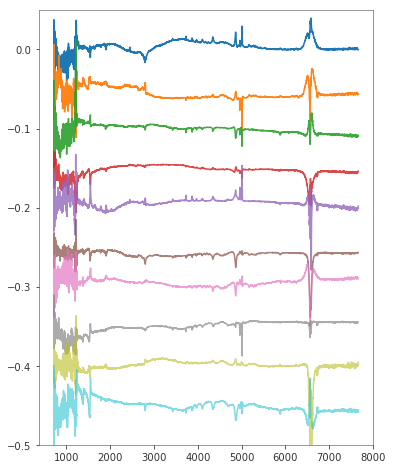

In [18]:
figure(figsize=(6,8))
for i in range(qso.nvec):
    plot(wave, qso.mvec[i] - 0.05*i, alpha=1-0.5*i/qso.nvec)
ylim(-0.5, 0.05)

CPU times: user 2min 8s, sys: 1.77 s, total: 2min 10s
Wall time: 2min 13s


In [15]:
foo[0:20]

array([  9.69013579e+03,   2.28525931e+03,   1.48924691e+03,
         1.27069026e+03,   1.11065491e+03,   8.23457515e+02,
         6.40573169e+02,   4.99848463e+02,   4.01439050e+02,
         3.34314898e+02,   3.58243797e-12,   2.42504782e-12,
         2.21478528e-12,   1.78522877e-12,   1.61965043e-12,
         1.40626389e-12,   1.39089042e-12,   1.15597525e-12,
         8.47150377e-13,   8.47150377e-13])

(-0.5, 0.05)

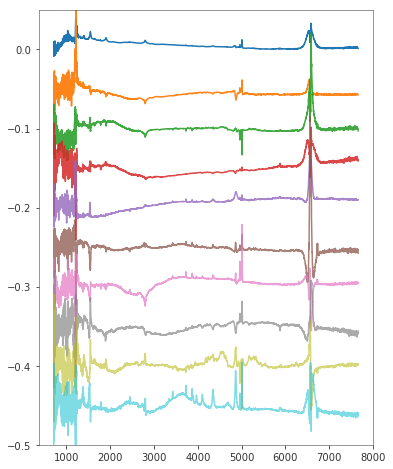

In [19]:
figure(figsize=(6,8))
for i in range(qso.nvec):
    plot(wave, qpca[i] - 0.05*i, alpha=1-0.5*i/qso.nvec)
ylim(-0.5, 0.05)

## Weight by S/N instead of 1/err^2 ##

In [20]:
snr = qso.model * np.sqrt(weights)
lyf = (wave<1216)
snr[lyf & (weights>0)] = 0.1
qso_snr = HMF(flux, snr, nvec=10)
qpca_snr = np.linalg.svd(qso_snr.model, full_matrices=False)[2]

(-0.5, 0.05)

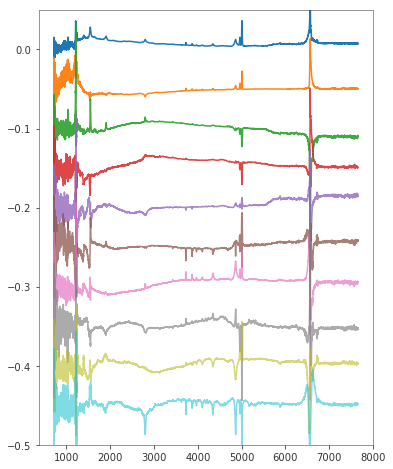

In [21]:
figure(figsize=(6,8))
for i in range(qso_snr.nvec):
    y = qpca_snr[i] * np.sign(np.sum(qpca_snr[i]))
    plot(wave, y - 0.05*i, alpha=1-0.5*i/qso_snr.nvec)
ylim(-0.5, 0.05)

In [164]:
for i in range(10):
    print(i, np.median(qpca_snr[i]), np.sum(qpca_snr[i]))

0 -0.0073095384112 -85.160963314
1 0.00109594365558 -12.006767996
2 -0.000752286699151 -7.28548661491
3 -0.00272737105092 -24.753272835
4 0.000450415262855 1.30522773254
5 0.00107583364266 15.7211789675
6 0.000605135979438 10.2552514681
7 0.000276162974589 4.52802153185
8 -0.00259553594622 -6.40142114556
9 -0.00148667494436 -8.91355488864


In [166]:
qpca_snr.shape, flux.shape

((5272, 10313), (5272, 10313))

In [262]:
coeff = flux.dot(qpca[0:10].T)
qpca_model = qpca[0:10].T.dot(coeff.T).T
qpca_model.shape

(5272, 10313)

1720


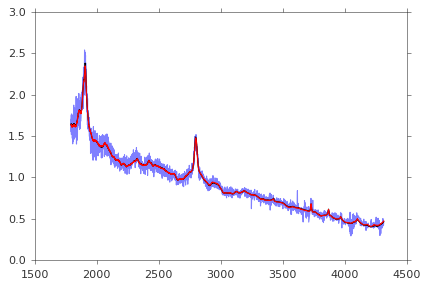

In [437]:
# i = 0
i += 20
print(i)
ii = (qso_snr.weights[i] > 0)
plot(wave[ii], qso_snr.data[i,ii], 'b-', alpha=0.5)
plot(wave[ii], qso_snr.model[i,ii], 'k-')

notlya = (wave>1218)
A = qpca_snr[0:10].T
Wx = spdiags(weights[i]*notlya, [0,], len(wave), len(wave))
c = np.linalg.solve(A.T.dot(Wx.dot(A)), A.T.dot(Wx.dot(flux[i])))
m = A.dot(c)
plot(wave[ii], m[ii], 'r-')
# ylim(0, 2); xlim(1200, 1600)

In [440]:
notlya = (wave>1218)
A = qpca_snr[0:10].T
cpca = np.zeros((qso.nobs,qso.nvec))
for i in range(flux.shape[0]):
    Wx = spdiags(weights[i]*notlya, [0,], len(wave), len(wave))
    cpca[i] = np.linalg.solve(A.T.dot(Wx.dot(A)), A.T.dot(Wx.dot(flux[i])))

In [573]:
lonorm = np.linalg.norm(cpca[:,0:5], axis=1)
hinorm = np.linalg.norm(cpca[:,5:], axis=1)
# ii = np.argsort(hinorm/lonorm)
ii = np.argsort(-np.abs(cpca[5]/cpca[0]))
i = -1

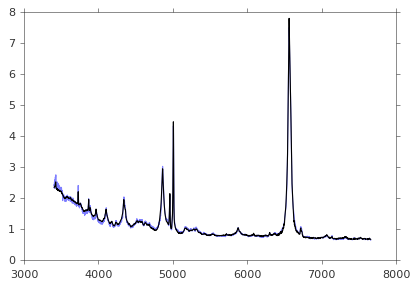

In [576]:
i += 1
j = ii[i]
jj = (qso_snr.weights[j] > 0)
plot(wave[jj], qso_snr.data[j,jj], 'b-', alpha=0.5)
plot(wave[jj], qso_snr.model[j,jj], 'k-')

In [447]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9
